Cell 1 — Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import pickle


Cell 2 — Load & inspect data

In [2]:

import os


csv_path = '../models/keypoint_classifier/keypoints.csv'

# Robustness check 
if not os.path.exists(csv_path):
    print(f"Error: File not found at {csv_path}")
    print(f"Current Working Directory is: {os.getcwd()}")
else:
    df = pd.read_csv(csv_path)
    print("CSV loaded successfully.")

print("Class distribution:")
print(df.iloc[:, 0].value_counts()) #class tag

# 2. Extract Data
# We use .iloc to grab columns by index regardless of their names
X = df.iloc[:, 1:].astype("float32").values  # All columns after the first
y = df.iloc[:, 0].astype("int32").values     # The first column

print("Feature shape:", X.shape)
print("Label shape:", y.shape)


CSV loaded successfully.
Class distribution:
0
3    735
4    312
1     47
0     44
2     27
Name: count, dtype: int64
Feature shape: (1165, 129)
Label shape: (1165,)


Cell 3 — Train / test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Cell 4 — Model definition & training 

In [4]:
#try lowering C value C=0.5 if landmark hand jitter is a problem You can tune the SVM to reduce sensitivity to small noise — but gently.
model = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True
    )
)

print("Training RBF SVM...")
model.fit(X_train, y_train)


Training RBF SVM...


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


Cell 5 — Basic evaluation (existing)

In [5]:
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9700

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       1.00      1.00      1.00         9
           2       1.00      0.80      0.89         5
           3       0.95      1.00      0.98       147
           4       1.00      0.92      0.96        63

    accuracy                           0.97       233
   macro avg       0.99      0.92      0.95       233
weighted avg       0.97      0.97      0.97       233



Cell 6 — Confusion matrix (gesture collision check)

Why this matters    

    Reveals which gestures are being confused

    Helps decide whether to:

    Improve features

    Redesign gestures

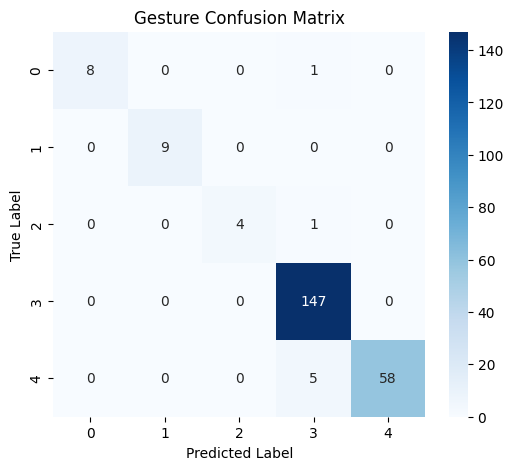

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Gesture Confusion Matrix")
plt.show()


Cell 7 — Confidence analysis (runtime readiness)

In [7]:
probs = model.predict_proba(X_test)
confidences = probs.max(axis=1)

correct = y_pred == y_test


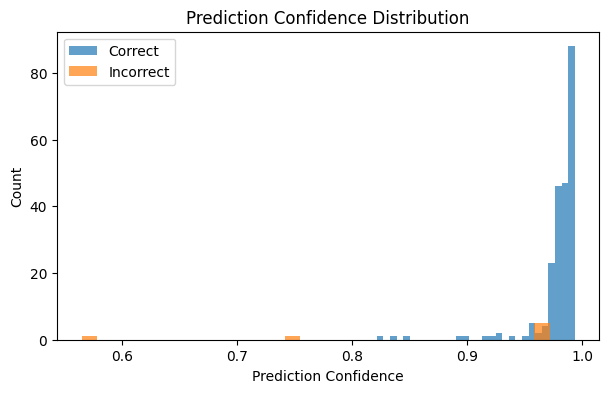

In [8]:
plt.figure(figsize=(7, 4))
plt.hist(confidences[correct], bins=30, alpha=0.7, label="Correct")
plt.hist(confidences[~correct], bins=30, alpha=0.7, label="Incorrect")
plt.xlabel("Prediction Confidence")
plt.ylabel("Count")
plt.legend()
plt.title("Prediction Confidence Distribution")
plt.show()


Cell 8 — Reject-option simulation (real-world behavior)

In [9]:
THRESHOLD = 0.7

accepted = confidences >= THRESHOLD

accepted_accuracy = accuracy_score(
    y_test[accepted],
    y_pred[accepted]
)

rejection_rate = 1.0 - accepted.mean()

print(f"Accuracy (accepted predictions only): {accepted_accuracy:.3f}")
print(f"Rejection rate: {rejection_rate:.3f}")


Accuracy (accepted predictions only): 0.974
Rejection rate: 0.004


Cell 9 — Save model

In [10]:
from pathlib import Path


save_folder = Path.cwd() / 'models'


save_folder.mkdir(parents=True, exist_ok=True)

model_path = save_folder / 'gesture_model.pkl'


with open('gesture_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as gesture_model.pkl")


Model saved as gesture_model.pkl
